In [23]:
import yfinance as yf
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
from datetime import datetime
import time
import pickle
import os
import requests
from bs4 import BeautifulSoup
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import time
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd


# 篩選股票

In [88]:
import pandas as pd
df = pd.read_excel('StockList.xlsx')
# 將資料存為 CSV，設定編碼為 'utf-8-sig' 支援中文
df.to_csv('StockList.csv', index=False, encoding='utf-8-sig')

# 讀取 CSV 文件
df = pd.read_csv('StockList.csv')
# 選擇需要的欄位
df.columns.values[8] = '現金股利'
col = ['代號', '名稱', '現金股利', '所屬EPS']


# 按現金股利由高至低排序
df = df[col]
df['篩選結果'] = df['現金股利'] / df['所屬EPS']*100
df['篩選結果'] = df['篩選結果'].round(2)
df['EPS篩選'] = df['所屬EPS']>=10
df = df[df['EPS篩選'] != False]
df = df.sort_values(by='篩選結果', ascending=False)

df = df[df['篩選結果']>=50]
# 去除代號欄位中的 =' 和 '
df['代號'] = df['代號'].str.strip('="')
# 重設索引（可選）
df.reset_index(drop=True, inplace=True)
df.set_index('代號', inplace=True)
ticker_list = list(df.index)
remove_items = ['6996', '6881', '6957', '6903']  # 要移除的元素列表

# 使用 list comprehension 過濾掉要移除的元素
ticker_list = [item for item in ticker_list if item not in remove_items]
#ticker_list


# 下載ticker_list所有資料

In [92]:
class Encapsulation:  # OBS : OverBoughtSold
    def __init__(self, ticker):
        self.ticker = ticker
        self.OverBoughtSold_n_days = {1: 'nan', 3: 'nan', 5: 'nan', 20: 'nan', 40: 'nan', 60: 'nan', 120: 'nan'}
        
        # 下載交易日期
        tsmc_data = yf.download('2330.TW', start="2024-01-01", end="2025-01-22")
        self.trade_date = [str(date) for date in tsmc_data.index.date]
        """
        self.headers = {
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36"
        }
        """
        self.headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36"
}


    def get_OverBoughtSold_n_days(self):
        Dict = {1: 'nan', 3: 'nan', 5: 'nan', 20: 'nan', 40: 'nan', 60: 'nan', 120: 'nan'}

        # 使用多線程爬取不同 lookback_n_days 的數據
        for lookback_n_days in [1, 3, 5, 20, 40, 60, 120]:
            start_time = time.time()

            KEYS = self.trade_date
            # 使用 ThreadPoolExecutor 進行並行處理
            with ThreadPoolExecutor() as executor:
                VALUES = list(executor.map(
                    lambda date: self.OBS(date, lookback_n_days),
                    self.trade_date
                ))
            
            Dict[lookback_n_days] = dict(zip(KEYS, VALUES))

            
            

            elapsed_time = time.time() - start_time
            print(f"lookback_n_days={lookback_n_days} 完成，執行時間: {elapsed_time:.2f} 秒")
            
        stock_data = yf.download(f"{self.ticker}.TW", start="2024-01-01", end="2025-01-22")  # 範圍包含所需日期
        if not stock_data.empty:
            print('TW')
        if stock_data.empty:
            stock_data = yf.download(f"{self.ticker}.TWO", start="2024-01-01", end="2025-01-22")
            print('TWO')
        Dict['Volume'] = stock_data['Volume']

        return Dict

    def get_url(self, start_dt, end_dt):
        return f"https://stockchannelnew.sinotrade.com.tw/z/zc/zco/zco.djhtm?a={self.ticker}&e={start_dt}&f={end_dt}"
        
    def OBS(self, current_date, lookback_n_days):
        current_idx = self.trade_date.index(current_date)
        lookback_idx = current_idx - lookback_n_days + 1
        lookback_date = self.trade_date[lookback_idx] if lookback_idx >= 0 else 'nan'
        if lookback_date == 'nan': return 'nan'
        
        url = self.get_url(lookback_date, current_date)
        
        # 發送請求
        response = requests.get(url, headers=self.headers)
        
        # 確保請求成功
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, "html.parser")
            
            # 找到目標表格
            table = soup.find("table", {"id": "oMainTable"})
            
            if table:
                rows = []
                # 遍歷表格行，提取數據並去除逗號
                for tr in table.find_all("tr")[8:]:  # 跳過前 8 行標題
                    cells = [td.get_text(strip=True).replace(",", "") for td in tr.find_all("td")]
                    if cells:  # 如果行有數據
                        rows.append(cells)
                
                # 定義表格欄位
                columns = ["買超券商", "(買超)買進", "(買超)賣出", "買超", "(買超)佔成交比重", 
                           "賣超券商", "(賣超)買進", "(賣超)賣出", "賣超", "(賣超)佔成交比重"]
                
                # 建立 DataFrame
                df = pd.DataFrame(rows, columns=columns)
                
                # 過濾掉合計與空行
                df = df[~df["買超券商"].str.contains("合計|平均", na=False)]
                
                # 提取數據
                KEYS = ['合計買超張數', '合計賣超張數', '平均買超成本', '平均賣超成本']
                VALUES = []
                rows = soup.find_all("tr", {"id": "oScrollFoot"})
                for row in rows:
                    cells = row.find_all("td", {"class": "t3n1"})
                    for cell in cells:
                        # 去除逗號
                        VALUES.append(cell.get_text(strip=True).replace(",", ""))
                
                NEW_COL_VALUE = dict(zip(KEYS, VALUES))
                df = df.assign(**NEW_COL_VALUE)

                """
                to_numeric_list = ["(買超)買進", "(買超)賣出", "買超", "(賣超)買進", "(賣超)賣出", "賣超", 
                           '合計買超張數', '合計賣超張數', '平均買超成本', '平均賣超成本']
                for col in to_numeric_list:
                    df[col] = pd.to_numeric(df[col])
                """
                return df
            else:
                print("未找到目標表格")
        else:
            print(f"請求失敗，狀態碼: {response.status_code}")

In [93]:
ticker_list = ['1477']
for ticker in ticker_list:
    print(ticker)
    obs = Encapsulation(ticker)
    Dict = obs.get_OverBoughtSold_n_days()
    # 設定資料夾名稱
    folder_name = "Stock_pickle"
    # 設定檔案路徑
    file_path = os.path.join(folder_name, f"{ticker}.pkl")
    # 儲存為 Pickle 文件
    with open(file_path, 'wb') as file:
        pickle.dump(Dict, file)
    

1477


[*********************100%***********************]  1 of 1 completed


lookback_n_days=1 完成，執行時間: 13.88 秒
lookback_n_days=3 完成，執行時間: 12.72 秒
lookback_n_days=5 完成，執行時間: 12.78 秒
lookback_n_days=20 完成，執行時間: 12.75 秒
lookback_n_days=40 完成，執行時間: 19.05 秒
lookback_n_days=60 完成，執行時間: 11.15 秒


[*********************100%***********************]  1 of 1 completed

lookback_n_days=120 完成，執行時間: 7.75 秒
TW


# 計算籌碼集中度

In [94]:
class SCR:
    def __init__(self, ticker):
        print(ticker)
        file_path = os.path.join("Stock_pickle", f"{ticker}.pkl")
        self.loaded_data = None
        with open(file_path, 'rb') as file:
            self.loaded_data = pickle.load(file)

        self.Volume = self.loaded_data['Volume']

        
        tsmc_data = yf.download('2330.TW', start="2024-01-01", end="2025-01-22")
        self.trade_dates = [str(date) for date in tsmc_data.index.date]
        #print(len(self.trade_dates))
        self.ticker = ticker
        n_days_list = [1,3,5,20,40,60,120]
        self.SCR_df = pd.DataFrame(index=self.trade_dates)

        for n_days in n_days_list:
            col_name = n_days
            col_data = [self.SCR(current_date, n_days) for current_date in self.trade_dates]
            self.SCR_df[col_name] = col_data
            

    def SCR(self, current_date, n_days):
        current_idx = self.trade_dates.index(current_date)
        lookback_idx = current_idx-n_days+1
        #print(lookback_idx)
        if lookback_idx<0: return 'nan'
        
        lookback_date = self.trade_dates[lookback_idx]
        D = self.loaded_data[n_days][current_date]

        up = pd.to_numeric(D['買超']).sum()-pd.to_numeric(D['賣超']).sum()
        down = self.Volume[lookback_date : current_date].sum()/1000
        scr = up / down *100
        scr = round(scr, 2)
        return scr

ticker_list = ['1477']
for ticker in ticker_list:
    A = SCR(ticker)
    file_path = os.path.join('SCR', f"{ticker}.csv")
    A.SCR_df.to_csv(file_path)  # index=False 不儲存索引欄
print('Done')

1477


[*********************100%***********************]  1 of 1 completed


Done


# 調出一日資料

In [84]:

loaded_data = None
with open("Stock_pickle/1477.pkl", 'rb') as file:
    loaded_data = pickle.load(file)


In [85]:
loaded_data[1]['2025-01-17'].to_csv('1477一日.csv', encoding='utf-8-sig')

In [86]:
loaded_data[3]['2025-01-17'].to_csv('1477三日.csv', encoding='utf-8-sig')

In [87]:
loaded_data[5]['2025-01-17'].to_csv('1477五日.csv', encoding='utf-8-sig')

In [83]:
loaded_data[3]['2025-01-17']

,買超券商,(買超)買進,(買超)賣出,買超,(買超)佔成交比重,賣超券商,(賣超)買進,(賣超)賣出,賣超,(賣超)佔成交比重,合計買超張數,合計賣超張數,平均買超成本,平均賣超成本
0,元大證券,321,50,271,8.13%,摩根大通,136,521,385,11.55%,1345,943,343.68,342.76
1,華南永昌,232,24,208,6.24%,台灣摩根士丹利,104,239,135,4.05%,1345,943,343.68,342.76
2,凱基-台北,511,364,147,4.41%,美林,154,247,93,2.79%,1345,943,343.68,342.76
3,中國信託,152,13,139,4.17%,元大-八德,0,69,69,2.07%,1345,943,343.68,342.76
4,群益金鼎,103,3,100,3%,新加坡商瑞銀,294,338,44,1.32%,1345,943,343.68,342.76
5,凱基,98,19,79,2.37%,富邦-陽明,8,50,42,1.26%,1345,943,343.68,342.76
6,富邦證券,93,24,69,2.07%,新光,17,45,28,0.84%,1345,943,343.68,342.76
7,美商高盛,140,81,59,1.77%,港商野村,108,134,26,0.78%,1345,943,343.68,342.76
8,元富,77,20,57,1.71%,港商麥格理,0,25,25,0.75%,1345,943,343.68,342.76
9,統一,68,17,51,1.53%,第一金,5,26,21,0.63%,1345,943,343.68,342.76


# 1.多頭排列：1日>5日>60日>120日

[*********************100%***********************]  1 of 1 completed


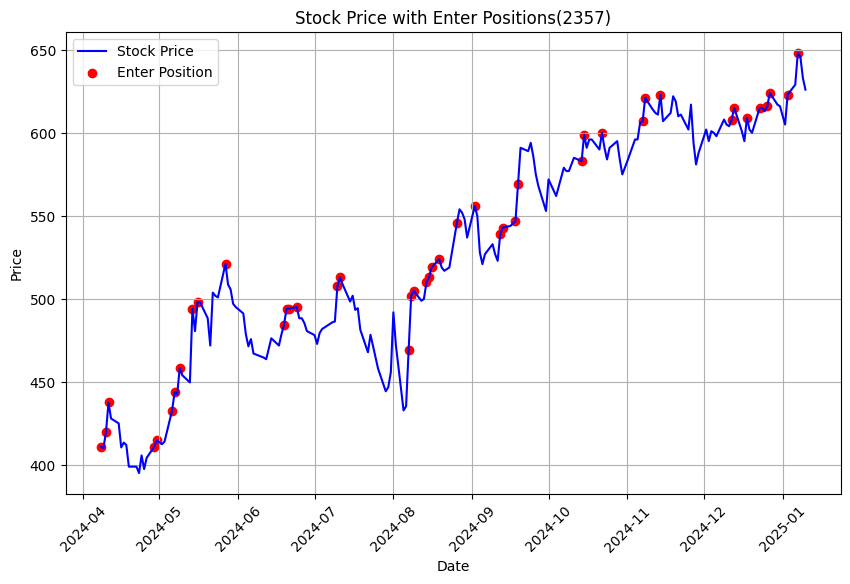

In [203]:
class EnterPosition:
    def __init__(self, ticker):
        self.ticker = ticker
        self.SCR_df = self.get_SCR_df()
        self.stock_price = self.get_stock_price()
        self.enter_position = self.get_EnterPosition()
        

    def get_SCR_df(self):
        file_path = os.path.join('SCR', f"{self.ticker}.csv")
        df = pd.read_csv(file_path, index_col=0)  # 假設索引是 CSV 中的第一列
        df.replace('nan', np.nan, inplace=True)
        df.dropna(inplace=True)  # 這裡進行就地刪除
        return df

    def get_stock_price(self):
        stock_data = yf.download(f"{ticker}.TW", start="2024-01-01", end="2025-01-16")
        if stock_data.empty:
            stock_data = yf.download(f"{ticker}.TWO", start="2024-01-01", end="2025-01-16")
        #df.index
        stock_data = stock_data.loc[self.SCR_df.index]
        stock_price = stock_data['Adj Close']
        # 確保 stock_price.index 也是 datetime 類型
        stock_price.index = pd.to_datetime(stock_price.index)
        return stock_price

    def get_EnterPosition(self):
        enter_position = []
        for date in self.SCR_df.index:
            single_day_date = self.SCR_df.loc[date]
            #SCR1, SCR5, SCR60, SCR120 = \
            #    single_day_date['1'], single_day_date['5'], single_day_date['60']#, single_day_date['120']
            SCR1, SCR5, SCR60 = \
                single_day_date['1'], single_day_date['5'], single_day_date['60']
            condition = (SCR1>SCR5) & (SCR5>SCR60) #& (SCR60>120)
            if condition: 
                enter_position.append(date)
                
        # 確保 enter_position 是 datetime 類型
        enter_position = pd.to_datetime(enter_position)
        return enter_position

    def plot_enter_position(self):
        # 繪製股票價格圖
        plt.figure(figsize=(10, 6))
        plt.plot(self.stock_price.index, self.stock_price, label='Stock Price', color='blue')
        
        # 在進場日期上標註紅點
        for i, date in enumerate(self.enter_position):
            if date in self.stock_price.index:  # 確保進場日期存在於 stock_price 中
                plt.scatter(date, self.stock_price.loc[date], color='red', 
                            label='Enter Position' if i == 0 else "")  # 只在第一個標註時設置 label
        
        # 設定圖表標題和標籤
        plt.title(f'Stock Price with Enter Positions({self.ticker})')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.xticks(rotation=45)
        plt.legend()
        
        # 顯示圖表
        plt.grid(True)
        plt.show()
        
                
E = EnterPosition('2357')
E.plot_enter_position()